In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from sklearn import metrics
from statistics import mean
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV , RepeatedStratifiedKFold , cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, median_absolute_error

In [24]:
# Data for 2005 to 2010 
dataset = pd.read_csv('../Data/features_2005_2010_new.csv')
dataset.head()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140720 entries, 0 to 1140719
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Unnamed: 0     1140720 non-null  int64  
 1   id             1140720 non-null  int64  
 2   diversity      1140720 non-null  float64
 3   venue_rank     1140720 non-null  float64
 4   venue_MPI      1140720 non-null  float64
 5   venue_TPI      1140720 non-null  float64
 6   productivity   1140720 non-null  float64
 7   H_index        1140720 non-null  float64
 8   author_rank    1140720 non-null  float64
 9   author_MPI     1140720 non-null  float64
 10  author_TPI     1140720 non-null  float64
 11  versatility    1140720 non-null  float64
 12  citation_1yr   1140720 non-null  float64
 13  citation_2yr   1140720 non-null  float64
 14  citation_5yr   1140720 non-null  float64
 15  citation_10yr  1140720 non-null  float64
 16  n_citation     1140720 non-null  int64  
 17  citation

In [25]:
# Data for 2010 to extract the paper ids from year 2010
id_2010 = pd.read_csv('../Data/papers2010.csv')
id_2010.head()

,Unnamed: 0,id,authors,title,year,n_citation,references,fos,venue
0,0,117599,"[{'name': 'Horacio Saggion', 'org': 'Universit...",Inserting rhetorical predicates for quasi-abst...,2010,1,"[4508078, 2082416349, 2101390659, 2169546346, ...","[{'name': 'Multi-document summarization', 'w':...","{'raw': ""RIAO '10 Adaptivity, Personalization ..."
1,1,133010,"[{'name': 'Vadim Ermolayev', 'org': 'Cadence D...",Articulation and Sharing of Distributed Design...,2010,2,"[53456027, 63764177, 99644187, 103455988, 1067...","[{'name': 'Project plan', 'w': 0.63773}, {'nam...",{'raw': 'IDC'}
2,2,182605,"[{'name': 'Rohit Kumar', 'org': 'Carnegie Mell...",Engaging learning groups using Social Interact...,2010,2,"[1510324139, 1980982162, 2101963588, 212166507...","[{'name': 'Social relation', 'w': 0.47114}, {'...",{'raw': 'North American Chapter of the Associa...
3,3,192912,"[{'name': 'Prokopios Drogkaris', 'org': 'Labor...",Attaching multiple personal identifiers in X.5...,2010,0,"[1660562555, 2088103037, 2092374634, 224378568...","[{'name': 'Internet privacy', 'w': 0.46058}, {...",{'raw': 'European Public Key Infrastructure Wo...
4,4,215073,"[{'name': 'Chunfeng Liu', 'org': 'Hebei Polyte...",Research on a Class of Ordinary Differential E...,2010,0,NaN,"[{'name': 'Slag', 'w': 0.42915}, {'name': 'Run...",{'raw': 'international conference on Informati...


In [26]:
# Split data for train and test 
ids = id_2010['id'].tolist() 
train = dataset[dataset['id'].isin(ids) == False]
test = dataset[dataset['id'].isin(ids)]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919995 entries, 0 to 1140719
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     919995 non-null  int64  
 1   id             919995 non-null  int64  
 2   diversity      919995 non-null  float64
 3   venue_rank     919995 non-null  float64
 4   venue_MPI      919995 non-null  float64
 5   venue_TPI      919995 non-null  float64
 6   productivity   919995 non-null  float64
 7   H_index        919995 non-null  float64
 8   author_rank    919995 non-null  float64
 9   author_MPI     919995 non-null  float64
 10  author_TPI     919995 non-null  float64
 11  versatility    919995 non-null  float64
 12  citation_1yr   919995 non-null  float64
 13  citation_2yr   919995 non-null  float64
 14  citation_5yr   919995 non-null  float64
 15  citation_10yr  919995 non-null  float64
 16  n_citation     919995 non-null  int64  
 17  citation       919995 non-nu

In [27]:
# Set ytrain and Xtrain
y_train_1yr = train.iloc[:,12]
y_train_2yr = train.iloc[:,13]
y_train_5yr = train.iloc[:,14]
y_train_10yr = train.iloc[:,15]

X_train = train.iloc[:,2:12]
print(y_train_5yr)
X_train.head()

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1140715    0.0
1140716    0.0
1140717    0.0
1140718    0.0
1140719    0.0
Name: citation_5yr, Length: 919995, dtype: float64


,diversity,venue_rank,venue_MPI,venue_TPI,productivity,H_index,author_rank,author_MPI,author_TPI,versatility
0,1.677395,11101.0,115.0,4188.0,170.000000,23.000000,3.447250e+05,132.000000,1927.000000,10.353863
1,1.068871,11101.0,115.0,4188.0,1.000000,0.000000,1.698048e+06,0.000000,0.000000,1.068871
2,1.821750,11101.0,115.0,4188.0,7.000000,2.000000,1.112349e+06,4.000000,10.000000,5.254207
3,1.081691,11101.0,115.0,4188.0,9.333333,3.666667,9.379188e+05,7.666667,47.333333,6.736735
4,2.869217,11101.0,115.0,4188.0,1.000000,0.000000,1.698048e+06,0.000000,0.000000,2.869217


In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220725 entries, 216 to 1140709
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     220725 non-null  int64  
 1   id             220725 non-null  int64  
 2   diversity      220725 non-null  float64
 3   venue_rank     220725 non-null  float64
 4   venue_MPI      220725 non-null  float64
 5   venue_TPI      220725 non-null  float64
 6   productivity   220725 non-null  float64
 7   H_index        220725 non-null  float64
 8   author_rank    220725 non-null  float64
 9   author_MPI     220725 non-null  float64
 10  author_TPI     220725 non-null  float64
 11  versatility    220725 non-null  float64
 12  citation_1yr   220725 non-null  float64
 13  citation_2yr   220725 non-null  float64
 14  citation_5yr   220725 non-null  float64
 15  citation_10yr  220725 non-null  float64
 16  n_citation     220725 non-null  int64  
 17  citation       220725 non-

In [29]:
# Set ytest and Xtest
y_test_1yr = test.iloc[:,12]
y_test_2yr = test.iloc[:,13]
y_test_5yr = test.iloc[:,14]
y_test_10yr = test.iloc[:,15]

X_test = test.iloc[:,2:12]
print(y_test_5yr)
X_test.head()

216        3.0
417        1.0
421        2.0
440        2.0
441        1.0
          ... 
1140665    0.0
1140681    0.0
1140688    1.0
1140700    0.0
1140709    0.0
Name: citation_5yr, Length: 220725, dtype: float64


,diversity,venue_rank,venue_MPI,venue_TPI,productivity,H_index,author_rank,author_MPI,author_TPI,versatility
216,3.561625,11101.0,115.0,4188.0,15.500000,5.000000,5.204462e+05,39.000000,125.500000,10.951452
417,1.669966,11101.0,115.0,4188.0,25.000000,6.000000,5.758400e+05,41.000000,161.000000,11.066745
421,1.992607,11101.0,115.0,4188.0,19.000000,4.000000,1.084376e+06,5.000000,34.000000,7.633989
440,2.749466,11101.0,115.0,4188.0,7.333333,2.666667,8.019018e+05,6.666667,32.333333,6.582855
441,3.376685,11101.0,115.0,4188.0,18.333333,4.666667,9.225598e+05,16.333333,87.333333,10.587081


# Train Model

In [30]:
def train_and_Predict(X_train, y_train, X_test):
    hgbr = HistGradientBoostingRegressor(learning_rate=0.15, max_iter=100, max_leaf_nodes=31, min_samples_leaf=20)
    model = hgbr.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return(y_pred)

In [31]:
y_predict_1yr = train_and_Predict(X_train, y_train_1yr, X_test)
y_predict_1yr

array([0.70223526, 0.59373485, 0.18109995, ..., 0.36542258, 0.11904764,
       0.11904764])

In [32]:
y_predict_2yr = train_and_Predict(X_train, y_train_2yr, X_test)
y_predict_1yr

array([0.70223526, 0.59373485, 0.18109995, ..., 0.36542258, 0.11904764,
       0.11904764])

In [33]:
y_predict_5yr = train_and_Predict(X_train, y_train_5yr, X_test)
y_predict_5yr

array([2.80961054e+00, 2.13853741e+00, 4.61970754e-01, ...,
       9.90181308e-01, 1.70281706e-03, 1.70281706e-03])

In [34]:
y_predict_10yr = train_and_Predict(X_train, y_train_10yr, X_test)
y_predict_10yr

array([3.72328119, 3.17744861, 0.6946372 , ..., 0.93928466, 0.0247585 ,
       0.0247585 ])

# Evaluation

In [35]:
print("Results for 1 year prediction:")
print("R squared:", r2_score(y_test_1yr, y_predict_1yr))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_1yr, y_predict_1yr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_1yr, y_predict_1yr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_1yr, y_predict_1yr)))
print('----------------------------------------')

print("Results for 2 year prediction:")
print("R squared:", r2_score(y_test_2yr, y_predict_2yr))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_2yr, y_predict_2yr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_2yr, y_predict_2yr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_2yr, y_predict_2yr)))
print('----------------------------------------')

print("Results for 5 year prediction:")
print("R squared:", r2_score(y_test_5yr, y_predict_5yr))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_5yr, y_predict_5yr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_5yr, y_predict_5yr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_5yr, y_predict_5yr)))
print('----------------------------------------')

print("Results for 10 year prediction:")
print("R squared:", r2_score(y_test_10yr, y_predict_10yr))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_10yr, y_predict_10yr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_10yr, y_predict_10yr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_10yr, y_predict_10yr)))

Results for 1 year prediction:
R squared: 0.08426397441811795
Mean Absolute Error: 1.186972307823082
Mean Squared Error: 47.36762680566386
Root Mean Squared Error: 6.882414315170503
----------------------------------------
Results for 2 year prediction:
R squared: 0.18846975830554213
Mean Absolute Error: 1.9251935270705538
Mean Squared Error: 75.14497167899535
Root Mean Squared Error: 8.66861994085537
----------------------------------------
Results for 5 year prediction:
R squared: 0.30453691775659353
Mean Absolute Error: 4.314922231335763
Mean Squared Error: 357.3286321536688
Root Mean Squared Error: 18.903138156233975
----------------------------------------
Results for 10 year prediction:
R squared: 0.2760867006712868
Mean Absolute Error: 7.248254820954615
Mean Squared Error: 1328.222060559483
Root Mean Squared Error: 36.444780978344255


In [37]:
def graph_hist(y_test, y_predict, bins, title):
    plt.hist([y_test, y_predict],range=(0,bins), bins = bins, label=['test', 'predict'])
    plt.legend(loc='upper right')
    plt.title(title)
    plt.show()

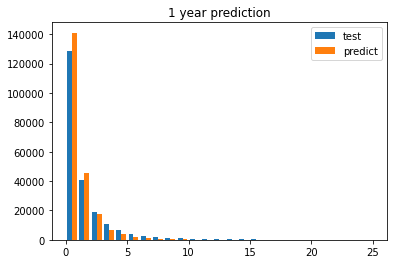

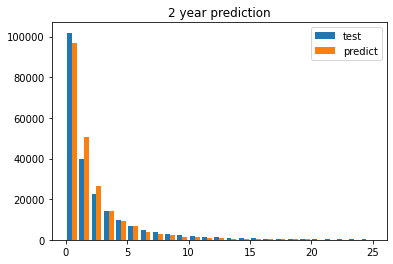

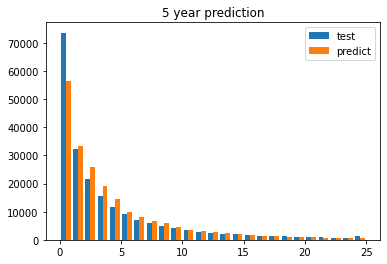

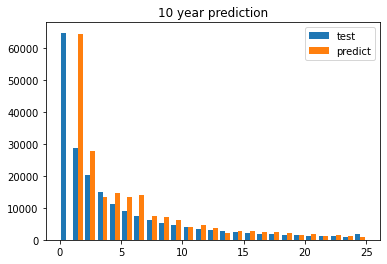

In [17]:
graph_hist(y_test_1yr, y_predict_1yr, 25, "1 year prediction")
graph_hist(y_test_2yr, y_predict_2yr, 25, "2 year prediction")
graph_hist(y_test_5yr, y_predict_5yr, 25, "5 year prediction")
graph_hist(y_test_10yr, y_predict_10yr, 25, "10 year prediction")

# Hyperparameter tuning

In [36]:
#TUNING 
from sklearn.model_selection import GridSearchCV
LR = {'max_depth': [1,2,3,4,5,6,7,8],'n_estimators': [5,25,50,100,150, 200,250,300],'learning_rate':[0.35,0.30,0.25,0.20,0.15, 0.10, 0.1,0.05]}

tuning = GridSearchCV(estimator=HistGradientBoostingRegressor(), cv = 3, param_grid=LR, scoring = 'r2')

tuning.fit(X_train,y_train_5yr)
tuning.best_params_, tuning.best_score_
#y_pred = tuning.predict(X_test)


ValueError: Invalid parameter n_estimators for estimator HistGradientBoostingRegressor(learning_rate=0.35, max_depth=1). Check the list of available parameters with `estimator.get_params().keys()`.

In [12]:
#EVALUATION
#tuning.cv_results_
#y_pred = tuning.predict(X_test)
MSE = ((y_pred-y_test)**2).mean()
score = r2_score(y_pred,y_test)


In [26]:
y_pred = y_pred[:25]
y_pred

array([ 3.70054981e+00,  2.62324381e+01,  2.06659634e+01,  7.99994961e+00,
        4.78438565e+00,  5.75664413e+00,  2.52100315e+01,  2.05024202e+02,
       -7.47324953e-05,  1.85875303e+01,  9.99996692e-01,  9.07661991e+00,
        2.99927136e+00,  2.55115061e+01,  9.99940825e-01])

In [27]:
y_test = y_test[:25]
y_test

array([  5,  27,   2,   9,   9,  11,  25, 118,   0,  33,   1,   6,   1,
        58,   1])